In [117]:
import pandas as pd
gsc_data = pd.read_csv('GSC+.csv', converters={'HPO_codes': eval, 'starts': eval, 'ends': eval, 'HPO_symptoms': eval})

In [141]:
gsc_data.shape

(228, 6)

In [142]:
gsc_data.iloc[0]['text']

'A syndrome of brachydactyly (absence of some middle or distal phalanges), aplastic or hypoplastic nails, symphalangism (ankylois of proximal interphalangeal joints), synostosis of some carpal and tarsal bones, craniosynostosis, and dysplastic hip joints is reported in five members of an Italian family. It may represent a previously undescribed autosomal dominant trait.'

In [143]:
gsc_data.iloc[0]['HPO_symptoms']

['brachydactyly',
 'absence of some middle or distal phalanges',
 'aplastic or hypoplastic nails',
 'hypoplastic nails',
 'symphalangism',
 'ankylois of proximal interphalangeal joints',
 'synostosis of some carpal and tarsal bones',
 'craniosynostosis',
 'dysplastic hip joints',
 'autosomal dominant trait',
 'autosomal dominant',
 'dominant',
 'dominant trait']

In [118]:
gsc_data.head()

,file,text,HPO_symptoms,HPO_codes,starts,ends
0,1003450,A syndrome of brachydactyly (absence of some m...,"[brachydactyly, absence of some middle or dist...","[0001156, 0009881, 0001798, 0001792, 0100264, ...","[14, 29, 74, 86, 105, 120, 166, 210, 232, 346,...","[27, 71, 103, 103, 118, 163, 208, 226, 253, 37..."
1,10051003,Townes-Brocks syndrome (TBS) is an autosomal d...,"[autosomal dominant disorder, autosomal domina...","[0000006, 0000006, 0000006, 0003828, 0003813, ...","[35, 35, 45, 95, 95, 139, 148, 163, 177, 186, ...","[62, 53, 53, 114, 103, 161, 161, 175, 197, 197..."
2,10066029,Nevoid basal cell carcinoma syndrome (NBCCS) i...,"[basal cell carcinoma, autosomal dominant, aut...","[0002671, 0000006, 0000006, 0000006, 0000006, ...","[7, 89, 89, 99, 99, 143, 143, 208, 238, 250, 2...","[27, 107, 113, 113, 107, 164, 151, 229, 261, 2..."
3,10196695,Angelman syndrome (AS) is a neurodevelopmental...,"[neurodevelopmental disorder, contiguous gene ...","[0000707, 0001466]","[28, 839]","[55, 863]"
4,10417280,Prader-Willi syndrome (PWS) and Angelman syndr...,"[neurobehavioral disorders, de novo]","[0000708, 0003745]","[68, 223]","[93, 230]"


In [119]:
# Create a similar columns for NCR output and MTA output 

In [47]:
import requests
def call_ncr(text):
    endpoint = 'https://ncr.ccm.sickkids.ca/curr/annotate/'
    r = requests.get(endpoint, params={'text': text})
    if r.status_code == 200:
        output = r.json()
        starts = [entry['start'] for entry in output['matches']]
        ends = [entry['end'] for entry in output['matches']]
        names = [entry['names'][0] for entry in output['matches']] # TODO should we stick with 0?
        hp_id = [entry['hp_id'][3:] for entry in output['matches']]
        scores = [entry['score'] for entry in output['matches']]
        return {
            'NCR_start': starts,
            'NCR_end': ends,
            'NCR_symptoms': names,
            'NCR_HPO_codes': hp_id,
            'NCR_confidence_score': scores,
        }
    else:
        print(r.text)
        return {}

In [48]:
sample_text = gsc_data.iloc[0]['text']

In [52]:
import time
ncr_rows = []
for ind, text in enumerate(gsc_data['text']):
    ncr_output = call_ncr(text)
    ncr_rows.append(ncr_output)
    if (ind + 1) % 10 == 0:
        print('Fetched {} rows'.format(ind + 1))
    time.sleep(1)
ncr_df = pd.DataFrame(ncr_rows)

Fetched 10 rows
Fetched 20 rows
Fetched 30 rows
Fetched 40 rows
Fetched 50 rows
Fetched 60 rows
Fetched 70 rows
Fetched 80 rows
Fetched 90 rows
Fetched 100 rows
Fetched 110 rows
Fetched 120 rows
Fetched 130 rows
Fetched 140 rows
Fetched 150 rows
Fetched 160 rows
Fetched 170 rows
Fetched 180 rows
Fetched 190 rows
Fetched 200 rows
Fetched 210 rows
Fetched 220 rows


In [54]:
ncr_df.head(10)

,NCR_start,NCR_end,NCR_symptoms,NCR_HPO_codes,NCR_confidence_score
0,"[0, 210, 74, 232, 166]","[27, 226, 103, 246, 208]","[Type A brachydactyly, Craniosynostosis, Aplas...","[0009370, 0001363, 0008386, 0001385, 0100266]","[0.854373, 0.9803171, 0.97019005, 0.9812449, 0..."
1,"[139, 163, 177, 202, 224, 246, 314, 344]","[161, 175, 197, 222, 240, 265, 333, 362]","[Abnormality of the outer ear, Hearing impairm...","[0000356, 0000365, 0100258, 0001199, 0002023, ...","[0.9629303, 0.9879309, 0.9797104, 0.9904183, 0..."
2,"[7, 704, 208, 238, 289, 330, 303, 447, 550]","[27, 716, 229, 273, 301, 357, 325, 476, 562]","[Basal cell carcinoma, Abnormality of skin pig...","[0002671, 0001000, 0002671, 0010603, 0010612, ...","[0.99626815, 0.8976064, 0.9970914, 0.98232365,..."
3,"[83, 205]","[104, 213]","[Prenatal maternal abnormality, Prenatal mater...","[0002686, 0002686]","[0.9450763, 0.93650734]"
4,[180],[188],[Prenatal maternal abnormality],[0002686],[0.93650734]
5,"[439, 376, 421, 504, 546, 77, 59, 138, 164, 298]","[468, 389, 434, 506, 559, 106, 72, 147, 183, 317]","[Abnormality of the seventh cranial nerve, Cho...","[0010827, 0009797, 0009797, 0500001, 0009797, ...","[0.95614415, 0.9940772, 0.9940772, 0.9919378, ..."
6,"[57, 84, 108, 124, 136, 155, 169, 268, 300, 27...","[82, 106, 119, 134, 153, 161, 186, 275, 323, 2...","[Intellectual disability, severe, Postnatal mi...","[0010864, 0005484, 0000154, 0000303, 0001344, ...","[0.99669075, 0.99157083, 0.9878103, 0.9828453,..."
7,"[0, 796, 119, 135, 191, 205, 928, 968, 1092, 1...","[17, 802, 130, 146, 201, 215, 938, 974, 1102, ...","[Neurofibromas, Neoplasm, Schwannoma, Meningio...","[0001067, 0002664, 0100008, 0002858, 0002858, ...","[0.995176, 0.98074406, 0.994758, 0.8937297, 0...."
8,"[0, 277, 265, 583, 625, 208, 219, 233, 249]","[19, 291, 272, 599, 639, 217, 231, 247, 259]","[Popliteal pterygium, Abnormality of the nail,...","[0009756, 0001597, 0000078, 0000202, 0000196, ...","[0.98863715, 0.9172121, 0.9366641, 0.9634072, ..."
9,"[136, 154, 178, 209, 1084, 312, 433, 486, 746,...","[152, 173, 191, 217, 1090, 317, 447, 505, 759,...","[Anal atresia, Triphalangeal thumb, Abnormalit...","[0002023, 0001199, 0000356, 0000365, 0001167, ...","[0.9931391, 0.9913281, 0.92845136, 0.98989284,..."


In [55]:
ncr_df.to_csv('ncr_output.csv')

In [56]:
# we have multisets here, how to do the overlap exactly?
# this could be sorted by positions

In [121]:
gsc_data.dtypes

file             int64
text            object
HPO_symptoms    object
HPO_codes       object
starts          object
ends            object
dtype: object

In [125]:
def jaccard_score(a, b):
    return len(set(a).intersection(set(b))) / len(set(a).union(set(b)))

In [131]:
from sklearn import metrics

def jaccard_evaluation():
    jaccard_scores = []
    for i, row in ncr_df.iterrows():
        gsc_row = gsc_data.iloc[i]
        gsc_codes = gsc_row['HPO_codes']
        ncr_codes = row['NCR_HPO_codes']
        score = jaccard_score(gsc_codes, ncr_codes)
        jaccard_scores.append(score)
    return jaccard_scores

In [132]:
jaccard_scores = jaccard_evaluation()

In [133]:
ncr_df['jaccard_overlap'] = jaccard_scores

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023254C5F8C8>]],
      dtype=object)

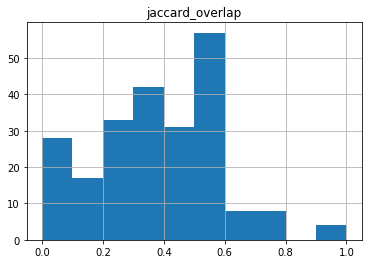

In [136]:
ncr_df.hist('jaccard_overlap')

In [139]:
ncr_df

,NCR_start,NCR_end,NCR_symptoms,NCR_HPO_codes,NCR_confidence_score,jaccard_overlap
0,"[0, 210, 74, 232, 166]","[27, 226, 103, 246, 208]","[Type A brachydactyly, Craniosynostosis, Aplas...","[0009370, 0001363, 0008386, 0001385, 0100266]","[0.854373, 0.9803171, 0.97019005, 0.9812449, 0...",0.153846
1,"[139, 163, 177, 202, 224, 246, 314, 344]","[161, 175, 197, 222, 240, 265, 333, 362]","[Abnormality of the outer ear, Hearing impairm...","[0000356, 0000365, 0100258, 0001199, 0002023, ...","[0.9629303, 0.9879309, 0.9797104, 0.9904183, 0...",0.357143
2,"[7, 704, 208, 238, 289, 330, 303, 447, 550]","[27, 716, 229, 273, 301, 357, 325, 476, 562]","[Basal cell carcinoma, Abnormality of skin pig...","[0002671, 0001000, 0002671, 0010603, 0010612, ...","[0.99626815, 0.8976064, 0.9970914, 0.98232365,...",0.500000
3,"[83, 205]","[104, 213]","[Prenatal maternal abnormality, Prenatal mater...","[0002686, 0002686]","[0.9450763, 0.93650734]",0.000000
4,[180],[188],[Prenatal maternal abnormality],[0002686],[0.93650734],0.000000
...,...,...,...,...,...,...
223,"[46, 670, 699, 686]","[56, 681, 709, 693]","[Overgrowth, Polyphagia, Overgrowth, Obesity]","[0001548, 0002591, 0001548, 0001513]","[0.99701005, 0.9962139, 0.99701005, 0.98880225]",1.000000
224,"[26, 120, 548, 226, 971, 810, 872, 469, 311, 394]","[59, 137, 554, 233, 1003, 816, 879, 476, 344, ...","[Unilateral vestibular Schwannoma, Neurofibrom...","[0009590, 0001067, 0002664, 0002664, 0009590, ...","[0.8733457, 0.995176, 0.98074406, 0.96545285, ...",0.181818
225,"[97, 705, 734, 158, 184, 286, 239, 953, 866, 809]","[117, 726, 750, 179, 200, 295, 245, 960, 886, ...","[Basal cell carcinoma, Basal cell carcinoma, M...","[0002671, 0002671, 0002885, 0002671, 0002885, ...","[0.99626815, 0.9970914, 0.8956474, 0.9970914, ...",0.600000
226,[],[],[],[],[],0.000000


Simple metrics:
* jaccard index
* other

Ontology based metrics:
* specificity
* ontology proximity

Semantical metrics:
* BioLink

Visualization:
* How to visualize the results?

Understand the differences and patterns:
* 

Slides
* answer the question which algorithm is better on average
* how often one is better than the other and vice versa
* when the one is better than the other? (try to find some categories)
* how many HPO we have here
* report metrics for both algorithms
* briefly describe the work done
* briefly describe the data